# Treebeards and the Fungus Amongus
The data we explore today (whatever day it is for you) is the [mushroom data](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/) found at the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).  

The type of exploration, you ask?  



![Treebeard](./assets/Treebeard.jpg)

Asking sentient trees what they know about poisonous mushrooms, of course.

In [9]:
# Get Mushroom Data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data

# Extract lines w/ feature names
#  -- you might use python to do this; I just use whatever quickly comes to mind
!cat agaricus-lepiota.names | grep "^[[:space:]]\{4,5\}[0-9]\{1,2\}.*:" > feature_names.txt

# Extract features names
with open('feature_names.txt') as f:
    features = [line.split()[1][0:-1] for line in f]

--2017-08-01 15:25:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names
Resolving archive.ics.uci.edu... 128.195.10.249
Connecting to archive.ics.uci.edu|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6816 (6.7K) [text/plain]
Saving to: ‘agaricus-lepiota.names.1’

agaricus-lepiota.na 100%[===================>]   6.66K  --.-KB/s    in 0.001s  

2017-08-01 15:25:56 (6.56 MB/s) - ‘agaricus-lepiota.names.1’ saved [6816/6816]

--2017-08-01 15:25:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data
Resolving archive.ics.uci.edu... 128.195.10.249
Connecting to archive.ics.uci.edu|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 373704 (365K) [text/plain]
Saving to: ‘agaricus-lepiota.data.1’

agaricus-lepiota.da 100%[===================>] 364.95K   464KB/s    in 0.8s    

2017-08-01 15:25:58 (464 KB/s) - ‘agaricus-lepiota.data.1’

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib inline

Read in the data with [pd.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html),
making sure to specify the names. (Simple inspection of the file shows that the target variable is in the first column, followed by the features.)

In [60]:
data = pd.read_csv('agaricus-lepiota.data', names=['deadly']+features)
y = pd.DataFrame([1 if target=='p' else 0 for target in data['deadly']], columns=['deadly'])
x = data.drop('deadly', axis=1)

# Train, Validate, Test
x_trn, x_vt, y_trn, y_vt = train_test_split(x, y, train_size=0.70)
x_val, x_tst, y_val, y_txt = train_test_split(x_vt, y_vt, test_size=0.50)

# Some/Most techniques require the categorical vars to be one-hot encoded
x_trn_code = pd.get_dummies(x_trn)
x_val_code = pd.get_dummies(x_val)
x_tst_code = pd.get_dummies(x_tst)

# Make sure the various dummy vars are represented in each subset
all_ftrs = pd.get_dummies(x).columns
for ftr in all_ftrs.difference(x_trn_code.columns): x_trn_code[ftr]=0
for ftr in all_ftrs.difference(x_val_code.columns): x_val_code[ftr]=0
for ftr in all_ftrs.difference(x_tst_code.columns): x_tst_code[ftr]=0

## Are these classes balanced or imbalanced?
Turns out they're pretty dang balanced, which means we don't have to think too much.
But beware: rarely are classes balanced in the "real" world.  (No, mushrooms are not real!)

In [59]:
y_trn.sum() / y_trn.count()

deadly    0.480654
dtype: float64

## A Tree
Interestingly, from a theoretical perspective, decision trees can handle categorical
variables just fine without one-hot encoding them.  However, [from an implementation perspective,
this is not necessarily true](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/). Turns out, one-hot encoding can degrade the performance (beware the curse of dimensionality!).  But [scikit-learn don't care](https://datascience.stackexchange.com/questions/5226/strings-as-features-in-decision-tree-random-forest)!  In scikit-learn, you **have** to one-hot encode the categorical features.  

Note that this is a bummer since one of the desirable traits of decision trees is the fact that they require almost no preprocessing (no need for logs or Box-Cox, normalization, etc).  So, one thing to add to this project is to also do a decision tree (and random forest) in R to see how the results differ.

In sklearn, we have various options for a [decision tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier):
* criterion: 
    - Default: 'gini' (Gini impurity)
    - 'entropy' (information gain)
* splitter: 
    - Default: 'best'
    - 'random'
* max_features
    - Default: None (max_features = n_features)
    - int (consider int features at each split), e.g., 3
    - float (percentage of total features considered at each split), e.g., 0.5
    - 'auto' (max_features = sqrt(n_features))
    - 'sqrt' (same as 'auto')
    - 'log2' (can you guess?)
* max_depth
    - Default: None (go deep!)
    - int: do not go further than int splits
    - if None, splits continue until all leaves are pure or min_samples_split is reached
* min_samples_split
    - Default: 2 (i.e., split until leaf is pure or some other constraint is met)
    - int (split if n_data_points_in_node >= int, barring no other constraint prevents such)
    - float (split if n_data_points_in_node >= ceil(float\*n_data_points), barring no other constraint)
* min_samples_leaf
    - 
* min_weight_fraction_leaf
* max_leaf_nodes
* class_weight
* random_state
* min_impurity_split

Whoa, all these options... It's like ice cream or beer: too many choices, damn it!

No worries... Let's just play around with them.  Maybe we will learn something!  
(Disclaimer: Or maybe not.)

In [94]:
gin_tree = DecisionTreeClassifier(random_state=0, criterion='gini')
ent_tree = DecisionTreeClassifier(random_state=0, criterion='entropy')

In [93]:
gin_tree.fit(x_trn_code, y_trn)
ent_tree.fit(x_trn_code, y_trn)
print('Gini:',    metrics.f1_score(y_val, gin_tree.predict(x_val_code)))
print('Entropy:', metrics.f1_score(y_val, ent_tree.predict(x_val_code)))

Gini: 0.347107438017
Entropy: 0.665173572228


You can do a "bootstrapping" of sorts by changing the random_state and finding the median. (Obviously this is ok for this small data set...but becomes less ok as N -> BIG!)

In [97]:
# Probably a more efficient way of doing this than forLoop, but uhhh... Look over there! -->
gf1=list(); ef1=list()
for i in range(1000):
    gin_tree = DecisionTreeClassifier(random_state=i, criterion='gini')
    ent_tree = DecisionTreeClassifier(random_state=i, criterion='entropy')
    gin_tree.fit(x_trn_code, y_trn)
    ent_tree.fit(x_trn_code, y_trn)
    gf1.append(metrics.f1_score(y_val, gin_tree.predict(x_val_code)))
    ef1.append(metrics.f1_score(y_val, ent_tree.predict(x_val_code)))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a38a5c0>]], dtype=object)

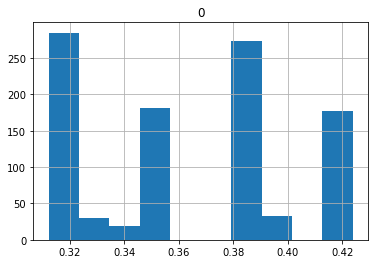

In [104]:
pd.DataFrame(gf1).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a4f72b0>]], dtype=object)

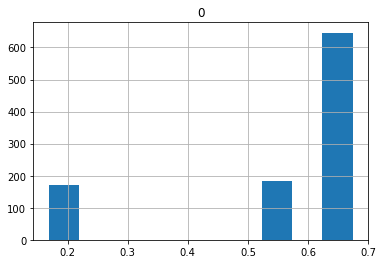

In [106]:
pd.DataFrame(ef1).hist()